In [1]:
import sys
sys.path.insert(0, "../")
from security import *

con_str = 'oracle://%s:%s@%s' % (odsprod_id, odsprod_pass, odsprod)

from sqlalchemy import create_engine
engine = create_engine(con_str)

engine.connect()

import pandas as pd

query="""
   SELECT
    fiscal_quarter,
    substr(fiscal_quarter, 6, 1) quarter,
    substr(fiscal_quarter, 0, 4) year,
    round(SUM(total_bookings_net) ) total_bookings_net,
    SUM(order_volume) order_volume
FROM
    (
        SELECT
            dv_fiscal_quarter_id fiscal_quarter,
            business_entity_name,
            offer_type,
            offer_code,
            SUM(total_sales_value_usd) total_bookings_net,
            SUM(web_cnt) order_volume
        FROM
            (
                SELECT
                    dv_fiscal_quarter_id,
                    DECODE(bk_business_entity_name,'UNKNOWN','Services',
                    DECODE(bk_business_entity_name,'Applications','Collaboration',bk_business_entity_name
) ) business_entity_name,
                    offer_type,
                    offer_code,
                    ( total_sales_value_usd ),
                    (
                        CASE
                            WHEN ROW_NUMBER() OVER(
                                PARTITION BY web_order_id,
                                dv_fiscal_quarter_id
                                ORDER BY
                                    web_order_id
                            ) = 1 THEN ROW_NUMBER() OVER(
                                PARTITION BY web_order_id,
                                dv_fiscal_quarter_id
                                ORDER BY
                                    web_order_id
                            )
                            ELSE 0
                        END
                    ) web_cnt
                FROM
                    reconciliation_booking_metrics a
            ) bkg
        GROUP BY
            dv_fiscal_quarter_id,
            business_entity_name,
            offer_type,
            offer_code
    ) xx
WHERE
    offer_type = 'WEBEX'
GROUP BY
    fiscal_quarter
ORDER BY
    fiscal_quarter
"""

df = pd.read_sql(query, con=engine.connect())
#df

In [2]:
#df.head()

In [3]:
%matplotlib inline
df = df.set_index('fiscal_quarter')
df = df.sort_index()
round(df,0)
df
#df[['dv_fiscal_quarter_id', 'sum']].plot(x='fiscal_year_month_int', y='sum')

,quarter,year,total_bookings_net,order_volume
fiscal_quarter,,,,
2018Q1,1,2018,83471226,3408
2018Q2,2,2018,143588916,4473
2018Q3,3,2018,240016863,5968
2018Q4,4,2018,366930411,6814
2019Q1,1,2019,87977905,4389


Text(0,0.5,'Volume')

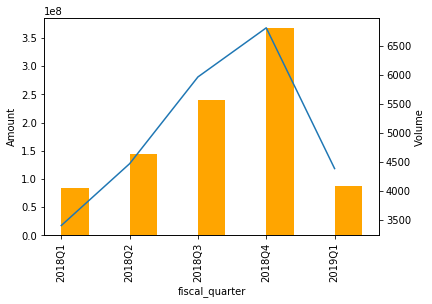

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

df.total_bookings_net.plot(kind='bar', color='orange', ax=ax, width=width, position=0)

df.order_volume.plot(kind='line',   ax=ax2 )

ax.set_ylabel('Amount')
ax2.set_ylabel('Volume')

## Train the function for prediction

In [6]:


predict = pd.DataFrame({'quarter':[2,3,4], 'year':2019}, index=['2019Q2', '2019Q3', '2019Q4'])
predict

merge = pd.concat([df, predict])
#merge.fillna(0,inplace=True)
merge.year = merge.year.astype(int)
merge.quarter = merge.quarter.astype(int) 

merge['base_booking'] = merge.groupby('year')['total_bookings_net'].transform('min')
merge['base_volume'] = merge.groupby('year')['order_volume'].transform('min')


merge['kind'] = merge.order_volume.apply(lambda val: 'Predict' if np.isnan(val) else 'Real')
merge

,order_volume,quarter,total_bookings_net,year,base_booking,base_volume,kind
2018Q1,3408.0,1,83471226.0,2018,83471226.0,3408.0,Real
2018Q2,4473.0,2,143588916.0,2018,83471226.0,3408.0,Real
2018Q3,5968.0,3,240016863.0,2018,83471226.0,3408.0,Real
2018Q4,6814.0,4,366930411.0,2018,83471226.0,3408.0,Real
2019Q1,4389.0,1,87977905.0,2019,87977905.0,4389.0,Real
2019Q2,NaN,2,NaN,2019,87977905.0,4389.0,Predict
2019Q3,NaN,3,NaN,2019,87977905.0,4389.0,Predict
2019Q4,NaN,4,NaN,2019,87977905.0,4389.0,Predict


## Fit to get the function

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
x = merge.quarter[:4]
booking = (merge.total_bookings_net - merge.base_booking)[:4]
volume =  (merge.order_volume - merge.base_volume)[:4]



w = np.polyfit (x, booking, 2)
predict_booking = np.poly1d(w)

w = np.polyfit (x, volume, 2)
predict_volume = np.poly1d(w)



## Predit

In [8]:

merge.total_bookings_net = merge.apply(lambda row: 
                                       row.total_bookings_net if pd.notna(row.total_bookings_net) else predict_booking(row.quarter) + row.base_booking,
                                                                              axis=1,
                                                                              )

merge.order_volume = merge.apply(lambda row: 
                                       row.order_volume if pd.notna(row.order_volume) else predict_volume(row.quarter) + row.base_volume,
                                                                              axis=1,
                                                                              )
merge

,order_volume,quarter,total_bookings_net,year,base_booking,base_volume,kind
2018Q1,3408.00,1,83471226.0,2018,83471226.0,3408.0,Real
2018Q2,4473.00,2,143588916.0,2018,83471226.0,3408.0,Real
2018Q3,5968.00,3,240016863.0,2018,83471226.0,3408.0,Real
2018Q4,6814.00,4,366930411.0,2018,83471226.0,3408.0,Real
2019Q1,4389.00,1,87977905.0,2019,87977905.0,4389.0,Real
2019Q2,5615.85,2,148969293.4,2019,87977905.0,4389.0,Predict
2019Q3,6787.15,3,243649843.6,2019,87977905.0,4389.0,Predict
2019Q4,7848.95,4,371728322.8,2019,87977905.0,4389.0,Predict


## Visual

Text(0,0.5,'Volume')

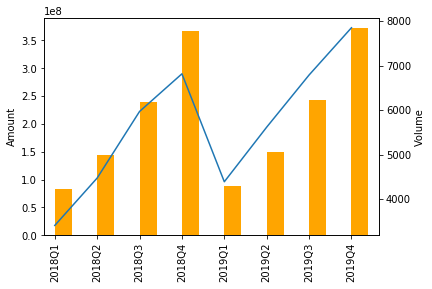

In [9]:
df = merge

fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

df.total_bookings_net.plot(kind='bar', color='orange', ax=ax, width=width, position=0)

df.order_volume.plot(kind='line',   ax=ax2 )

ax.set_ylabel('Amount')
ax2.set_ylabel('Volume')

In [10]:
df.total_bookings_net.plot?

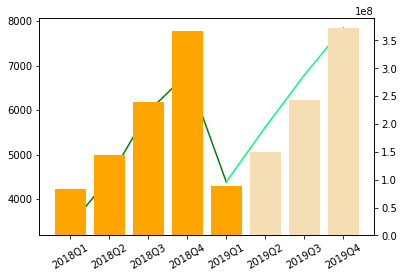

In [46]:
from functools import lru_cache
@lru_cache()
def get_color(kind, style):
    if kind =='Real' and style=='bar':
        return 'orange'
    elif kind =='Predict' and style=='bar':
        return 'wheat'
    elif kind =='Real' and style=='line':
        return 'green'
                
    elif kind =='Predict' and style=='line':
        return 'springgreen'
    else:
        return 'red'
    


xy = list(df.order_volume.iteritems() )
kinds = df.kind
fig, ax = plt.subplots()
for start, stop, kind in zip(xy[:-1], xy[1:], kinds[1:]):
    x, y = zip(start, stop)
    ax.plot(x, y, color=get_color(kind, 'line'))
   
ax2 = ax.twinx()
for x, y, kind in zip(df.index, df.total_bookings_net, kinds):  
    ax2.bar(x, y, color=get_color(kind, 'bar'))
    
for tick in ax.get_xticklabels():
    tick.set_rotation(30)
    
plt.show()